## 6 Filter bubbles (aggregate scores)

This is the goal of the notebook (based on the research Question 1.d):

We assume that by looking at which videos a YouTube user comments on, we can infer their viewing preferences. AllSides foundation labells news channels as having or not having a political bias. Based on our assumption before about infering preferences of YouTube users, it would follow that by looking at a user's comments, we can also infer their political bias. I.e. by aggregating the metadata of the videos they commented on.

We aggregate the political-bias-labels of the videos-a-user-has-commented-on into a score:

1. As a sum. We score each user by summing up the political leaning of each video using the following scores -1: left, -0.5: left-leaning, 0: centre, 0.5: right-leaning, 1: right. A score of -500 means that you have 500 more comments on left wing channels than on other channels. A score of 0 means that you commented equally much on right and left wing channels. Our hypothesis is that in a filter bubble scenario, we will observe that the frequency of extreme scores, will be higher than the frequency of moderate scores. I.e. a bimodal distribution with the means of the modes rather different from 0.

2. As a ratio with codomain (0,1). We score each user by making a ratio of right wing videos / total biased videos. A ratio of 0 means that a user has watched only left wing videos, a ratio of 0.5 means that a user has commented on left and right wing videos equally.

In both of the above cases, a user commenting on a unbiased video (political bias labelled as "centre") has no effect on their score.


In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

### Data Exploration

In [ ]:
df_comments = pd.merge(pd.read_csv('data/df_people_channel.csv.gz',compression='gzip', dtype='category'),\
         pd.read_csv('data/df_nodes.csv'),\
         right_on="Id",left_on="channel_id").drop('Id',axis=1)
#df_comments = pd.read_pickle('data/var_df_comments.pkl')

# Transform media_bias_rating to numbers to be able to aggregate them
df_comments['media_bias_rating'] = df_comments['media_bias_rating'].map({'Left':-1,'Lean Left':-0.5,'Right':1,'Center':0,'Lean Right':0.5}) 
df_comments.head(1)

,channel_id,author,video_id,channel_title,media_bias_rating,color,Label
0,UCrvhNP_lWuPIP6QZzJmM-bw,8950712,3g7BY6sRhnU,New York Post,0.5,#ff6766,New York Post (Lean Right)


Counts of authors, channels and videos.

In [ ]:
df_comments[['channel_id','author','video_id']].describe()

,channel_id,author,video_id
count,113260595,113260595,113260595
unique,137,15009226,267606
top,UCupvZG-5ko_eiXAupbDfxWw,8819632,faI8kacPGbQ
freq,18008087,24927,146206


Let's look at the youtube comment authors in our dataset. Specifically, the number of comments for each author:

In [ ]:
authors = df_comments.author.value_counts()
authors.describe().apply('{0:.1f}'.format)


count    18084101.0
mean            6.3
std            57.5
min             0.0
25%             1.0
50%             1.0
75%             3.0
max         24927.0
Name: author, dtype: object

The distribution of comments over authors. We notice the distribution is not exactly a power law. This is slightly problematic, and motivates the ways in which we try to make more "fair" comparisons between authors and their comments.

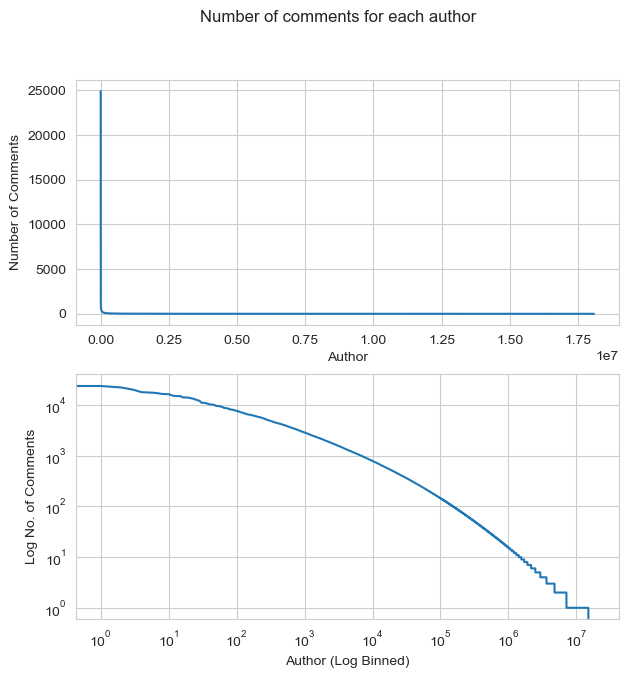

In [ ]:
authors = authors.reset_index().drop('index',axis=1).reset_index()
authors_plot, authors_plot_axs = plt.subplots(2, 1)
authors_plot_axs[0].set(xlabel='Author', ylabel='Number of Comments')
sns.lineplot(ax=authors_plot_axs[0], data=authors, x='index', y='author')

sns.lineplot(ax=authors_plot_axs[1], data=authors, x='index', y='author')
authors_plot_axs[1].set(xlabel='Author (Log Binned)', ylabel='Log No. of Comments', xscale='log', yscale='log')
authors_plot.set(size_inches= (7, 7))
authors_plot.suptitle('Number of comments for each author')

plt.savefig("./assets/authors_comments.png", dpi=400)

pickle.dump((authors_plot, authors_plot_axs), open('data/var_authors_plot_authors_plot_axs.pkl', 'wb'))

# authors_plot, authors_plot_axs = pickle.load(open('data/var_authors_plot_authors_plot_axs.pkl','rb'))

In [ ]:
del authors_plot, authors_plot_axs # optimize memory

How many **unique** channels and videos authors commented in the dataset. The median author comments on 1 unique video and channel respectively. While top quartile authors comment on at least 3 and 2 respectively.

In [ ]:
# authors_stats = df_comments.groupby(['author']).nunique().describe()
# authors_stats = authors_stats.apply(lambda s: s.apply('{0:.1f}'.format))
authors_stats = pickle.load(open('data/var_authors_stats','rb'))
authors_stats

,channel_id,video_id
count,18084101.0,18084101.0
mean,2.3,5.5
std,3.3,33.1
min,1.0,1.0
25%,1.0,1.0
50%,1.0,1.0
75%,2.0,3.0
max,101.0,11634.0


In [ ]:
del authors_plot, authors, authors_stats # memory optimization

The distribution of comments over political factions

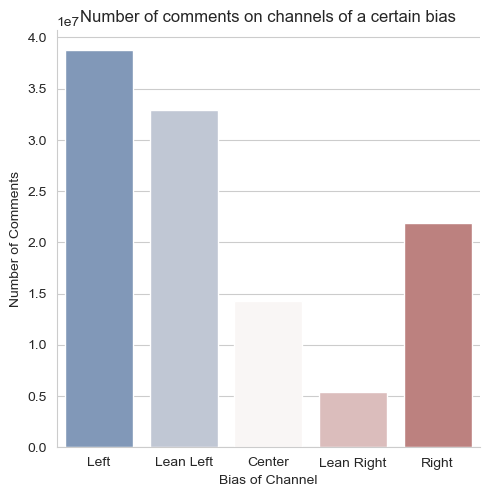

In [ ]:
g = sns.catplot(data=df_comments, x="media_bias_rating", kind="count",order=[-1,-0.5,0,0.5,1], palette='vlag')\
            .set_xticklabels(['Left','Lean Left','Center','Lean Right','Right'])\
            .set(xlabel="Bias of Channel", ylabel="Number of Comments", \
                title="Number of comments on channels of a certain bias")

plt.savefig("./assets/comments_by_bias.png", dpi=400)

### Pre-Analysis

In [ ]:
# Transform some columns from categorical to numeric. When filtering datasets and then showing value 
# counts or histplots, the categories that have been filtered out will show as 0. This was not 
# desirable for the following analyses. So we decided to convert them to numeric instead of having
# to filter the 0 categories out every time.
df_comments.media_bias_rating = pd.to_numeric(df_comments.media_bias_rating)
df_comments.author = pd.to_numeric(df_comments.author)

### Analysis 1: Aggregate the political bias of an author as a sum

Note that the initial thesis is:

We score each user by summing up the political leaning of each video using the following scores -1: left, -0.5: left-leaning, 0: centre, 0.5: right-leaning, 1: right. A score of -500 means that you have 500 more comments on left wing video channels than on other channels - **a biased comment author**. A score of 0 means that one commented equally much on right and left wing channels - **an unbiased author**. Our hypothesis is that in a filter bubble scenario, we will observe that the frequency of extreme scores, will be higher than the frequency of moderate scores. I.e. a bimodal distribution with the means of the modes rather different from 0.

In [ ]:
def bias_by_author(df_comments,comments_treshold,lower_bound,upper_bound):
    """Filter out the authors that have less than comments_treshold comments. 
    Then groupby author, and then for each author, sum the biases of the videos on which 
    they commented on. Sort the values, and then remove some the outliers with
    lower and upper bounds. Return a series with the index as unique comment author names, 
    and their "aggregate bias score" after the filtering as values.

    :param comments_treshold: treshold for minimum number of comments
    :param lower_bound: lower bound for values (measured from the beginning of array)
    :param upper_bound: upper bound for values (measured from the end of array)


    """
    return df_comments[df_comments.groupby("author")['author'].transform('size') > comments_treshold]\
                .groupby('author')['media_bias_rating']\
                .sum()\
                .sort_values()\
                .iloc[lower_bound:upper_bound]

Since comments over authors is not exactly a power law, we need to find some alternative ways to visualise the data. We find that filtering the extreme commenters (those that commented too much or too little), seems to increase the "signal" in the plots. Below you can see alternative "views" of the distribution.

Text(0.5, 0.98, 'Comment authors and their bias (negative - left wing, positive - right wing)')

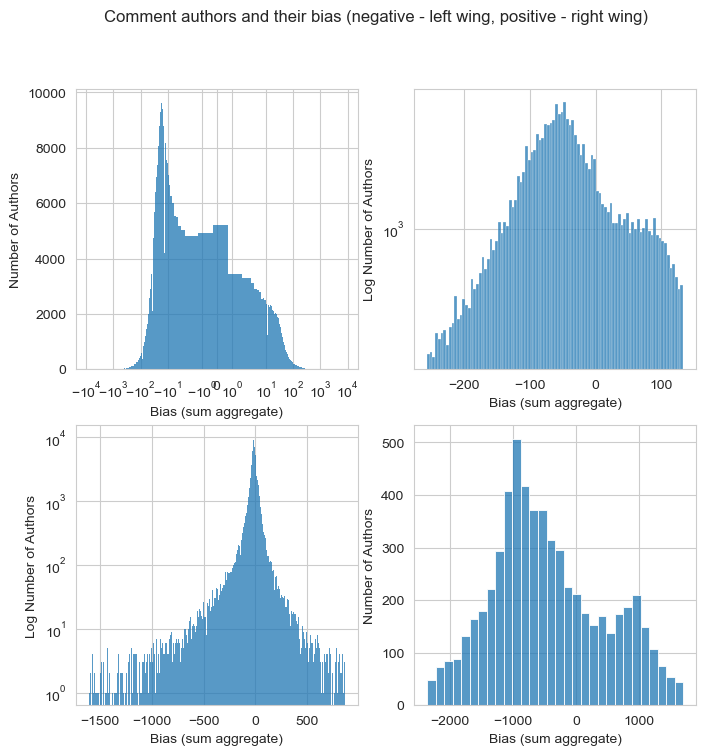

In [ ]:
fig,axs = plt.subplots(2,2, figsize=(8,8))

sns.histplot(x=bias_by_author(df_comments,comments_treshold=30,lower_bound=None,upper_bound=None),\
            ax = axs[0,0])
axs[0,0].set_xscale('symlog')
axs[0,0].set(xlabel="Bias (sum aggregate)", ylabel="Number of Authors")

sns.histplot(x=bias_by_author(df_comments,comments_treshold=30,lower_bound=1000,upper_bound=-1000),\
            ax = axs[1,0])
axs[1,0].set_yscale('log')
axs[1,0].set(xlabel="Bias (sum aggregate)", ylabel="Log Number of Authors")

sns.histplot(x=bias_by_author(df_comments,comments_treshold=100,lower_bound=15000,upper_bound=-15000),\
            ax = axs[0,1])
axs[0,1].set_yscale('log')
axs[0,1].set(xlabel="Bias (sum aggregate)", ylabel="Log Number of Authors")

sns.histplot(x=bias_by_author(df_comments,comments_treshold=1000,lower_bound=500,upper_bound=-300),\
            ax = axs[1,1])
axs[1,1].set(xlabel="Bias (sum aggregate)", ylabel="Number of Authors")

fig.suptitle('Comment authors and their bias (negative - left wing, positive - right wing)')

We can see that neither a logarithmic axes look like they yield much "signal" with the sum aggregation. We find than the most interesting plot is where extreme commenters are removed (i.e. no commenters below 1000 comments, and we also removed the very high bias scores at the extreme ends of the plot - they have extremely high scores because they also comment a lot) and there is no logarithm.

Text(0, 0.5, 'Number of Authors')

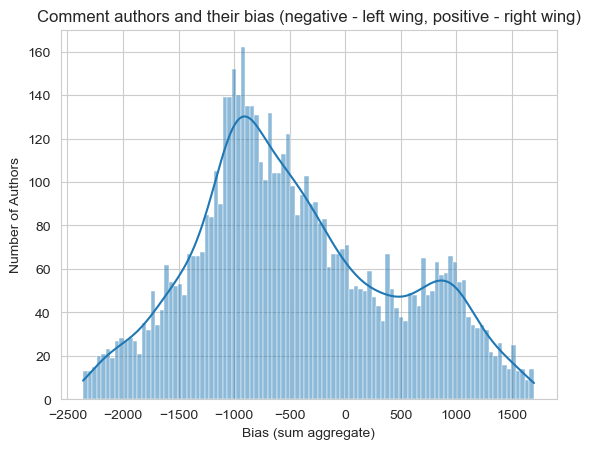

In [ ]:
g = sns.histplot(x=bias_by_author(df_comments,comments_treshold=1000,lower_bound=500,upper_bound=-300),kde=True, bins=100)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

#### Analysis 1.b: equalize distribution of comments over political biases by subsampling.

We don't know if our sample of comments reflects the population distribution of comments over political biases. As shown before, left wing comments dominate in our dataset. When looking at probabilities, if a user can only watch videos from our dataset, they are more likely to watch left wing videos just because there are much more of them! 

We construct a new dataset, where there is an equal amount of comments for each political bias, by picking random subsamples of comments from each category. By levelling up the distribution of comments over political biases, we address this bias of the sample. Since the subsamples are random, we are also not likely to introduce new biases (not aready present) in the data with respect to other characteristics about the comments.

Subsample class -1.0 so class 1.0 and -1.0 are equal in size. Ignore center votes. Filter bubbless very apparent in this configuration.

In [ ]:
left = df_comments[df_comments.media_bias_rating == -1.0].sample(n=df_comments.media_bias_rating.value_counts()[1.0])
right = df_comments[df_comments.media_bias_rating == 1.0]
df_comments_1a = pd.concat([left,right],axis=0)
print(left.shape,right.shape,df_comments_1a.shape)

(21892810, 7) (21892810, 7) (43785620, 7)


Text(0, 0.5, 'Number of Authors')

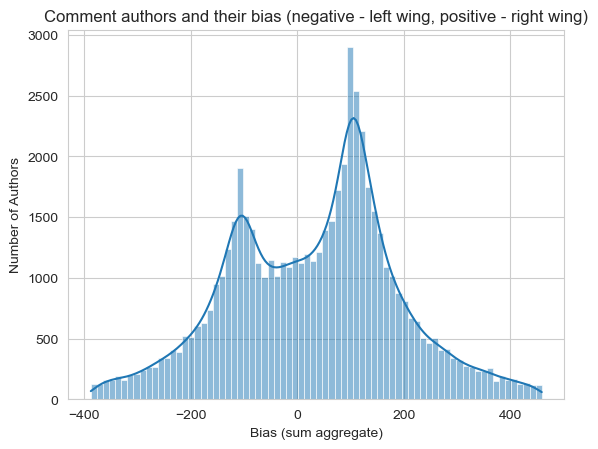

In [ ]:
g = sns.histplot(x=bias_by_author(df_comments_1a,comments_treshold=100,lower_bound=3000,upper_bound=-3000),kde=True)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

Text(0, 0.5, 'Number of Authors')

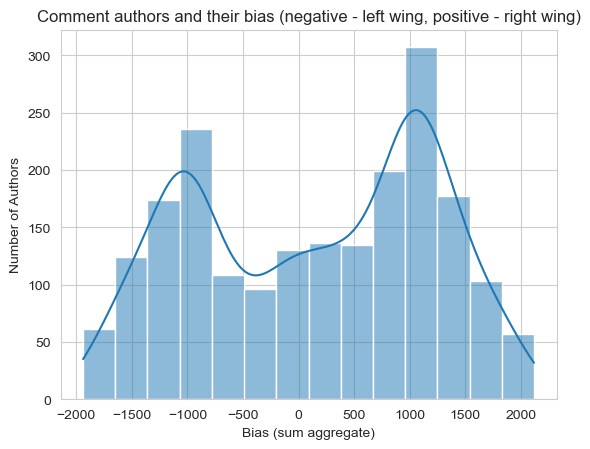

In [ ]:
g = sns.histplot(x=bias_by_author(df_comments_1a,comments_treshold=1000,lower_bound=200,upper_bound=-200),kde=True)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

Subsample all classess to the smallest denominator, include lean right and lean left. Here, filter bubbles appear only to the right wing.

In [ ]:
SUBSAMPLE_N = df_comments.media_bias_rating.value_counts().min()

a = df_comments[df_comments.media_bias_rating == -1.0].sample(n=SUBSAMPLE_N)
b = df_comments[df_comments.media_bias_rating == -0.5].sample(n=SUBSAMPLE_N)
c = df_comments[df_comments.media_bias_rating == 0.0].sample(n=SUBSAMPLE_N)
d = df_comments[df_comments.media_bias_rating == 1.0].sample(n=SUBSAMPLE_N)
e = df_comments[df_comments.media_bias_rating == 0.5].sample(n=SUBSAMPLE_N)
df_comments_1a_2 = pd.concat([a,b,c,d,e],axis=0)
del a,b,c,d,e # memory optimization
df_comments_1a_2.groupby('media_bias_rating').size()

media_bias_rating
-1.0    5410492
-0.5    5410492
 0.0    5410492
 0.5    5410492
 1.0    5410492
dtype: int64

Text(0, 0.5, 'Number of Authors')

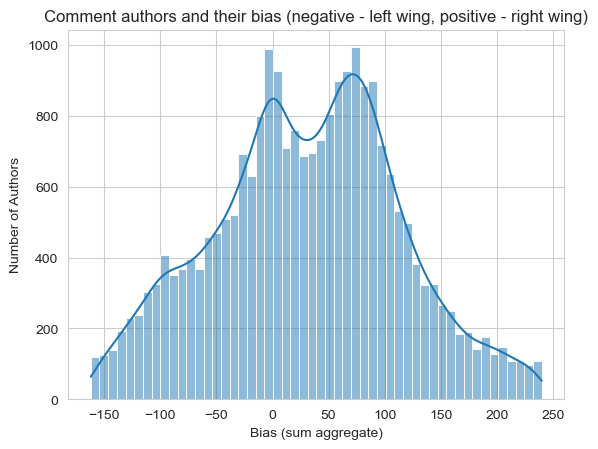

In [ ]:
g = sns.histplot(x=bias_by_author(df_comments_1a_2,comments_treshold=100,lower_bound=1500,upper_bound=-1500),kde=True)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

#### Analysis 1.c : Matched propensity scores

Finally, seeing whether the results stay the same on a dataset where the channels have been matched by propensity scores based on more broad channel details (viewcount etc.).

In [ ]:
df_channels_matched = pd.read_csv('data/df_news_matched.csv')
df_comments_matched = df_comments[df_comments.channel_id.isin(df_channels_matched.channel_id)]
df_comments_matched.shape

(42368607, 7)

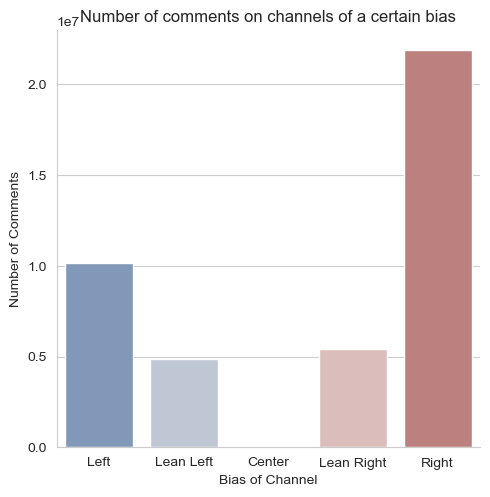

In [ ]:
sns.catplot(data=df_comments_matched, x="media_bias_rating", kind="count",order=[-1,-0.5,0,0.5,1], palette='vlag')\
            .set_xticklabels(['Left','Lean Left','Center','Lean Right','Right'])\
            .set(xlabel="Bias of Channel", ylabel="Number of Comments", \
                title="Number of comments on channels of a certain bias")

Answer is yes, we still see filter bubbles, albeit with some differences.

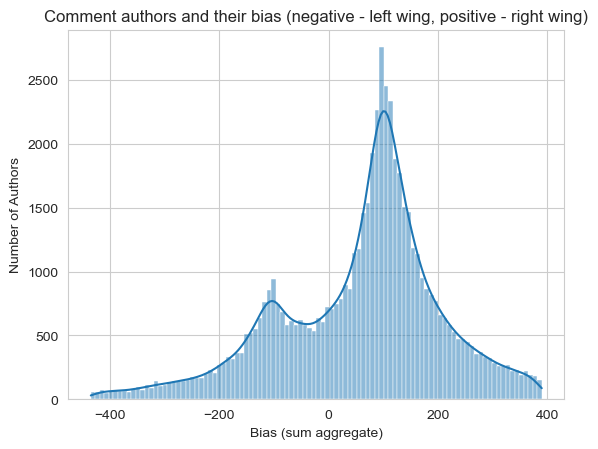

In [ ]:
g = sns.histplot(x=bias_by_author(df_comments_matched,comments_treshold=100,lower_bound=2000,upper_bound=-5000),kde=True, bins=100)
g.set_title('Comment authors and their bias (negative - left wing, positive - right wing)')
g.set_xlabel('Bias (sum aggregate)')
g.set_ylabel('Number of Authors')

plt.savefig("./assets/authors_bias_sum.png", dpi=400)

### Analysis 2: Aggregate the political bias of an author as a ratio

In the previous analysis, we ignore the fact that authors comment for a vastly different number of times. Even so, the results show filter bubbless especially after balancing the comments over authors distribution (by removing extreme values). In this section, we will aggreggate in a way that doesn't take the number of comments of an author into account at all, just the "direction" of an author's comments.

We score each user by making a ratio of right wing videos / total biased videos. A ratio of 0 means that a user has watched only left wing videos, a ratio of 0.5 means that a user has commented on left and right wing videos equally.

In [ ]:
authors_bias = df_comments.groupby(['author','media_bias_rating']).size().unstack(fill_value=0)
authors_bias['ratio'] = (authors_bias[1.0]+authors_bias[0.5])/(authors_bias[-1.0]+authors_bias[-0.5]+authors_bias[1.0]+authors_bias[0.5])
authors_bias = authors_bias.dropna()
authors_bias.head()

media_bias_rating,-1.0,-0.5,0.0,0.5,1.0,ratio
author,,,,,,
24,0,1,0,0,0,0.0
30,0,2,0,0,0,0.0
73,1,0,0,0,0,0.0
97,0,2,0,0,0,0.0
269,3,2,1,0,0,0.0


Authors that didn't comment on any biased videos?

In [ ]:
len(authors_bias[(authors_bias[-1.0]== 0) & (authors_bias[-0.5]== 0) & (authors_bias[1.0]==0) & (authors_bias[0.5]== 0)])

0

Text(0, 0.5, 'Number of Authors')

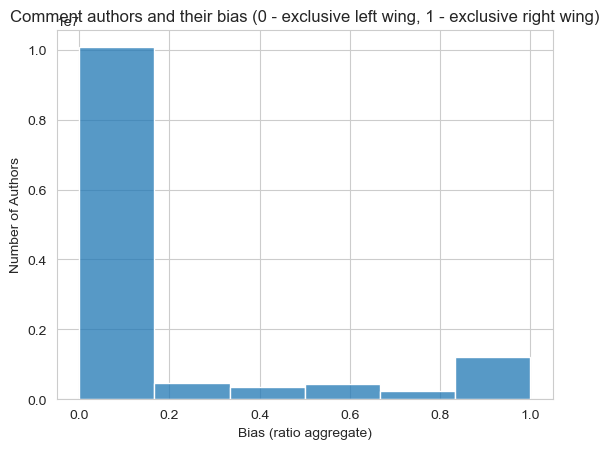

In [ ]:
g = sns.histplot(data=authors_bias, x='ratio',bins=6)
g.set_title('Comment authors and their bias (0 - exclusive left wing, 1 - exclusive right wing)')
g.set_xlabel('Bias (ratio aggregate)')
g.set_ylabel('Number of Authors')

#### Analysis 2.b: Subsample comments to level out the distribution

We don't know if our sample of comments reflects the population distribution of comments over political biases. As shown before, left wing comments dominate in our dataset. When looking at probabilities, if a user can only watch videos from our dataset, they are more likely to watch left wing videos just because there are much more of them! 

We construct a new dataset, where there is an equal amount of comments for each political bias, by picking random subsamples of comments from each category. By levelling up the distribution of comments over political biases, we address this bias of the sample. Since the subsamples are random, we are also not likely to introduce new biases (not aready present) in the data with respect to other characteristics about the comments.

In [ ]:
df_comments.groupby('media_bias_rating').size()

media_bias_rating
-1.0    38764195
-0.5    32872211
 0.0    14320887
 0.5     5410492
 1.0    21892810
dtype: int64

In [ ]:
a = df_comments[df_comments.media_bias_rating == -1.0].sample(n=df_comments.groupby('media_bias_rating').size().min())
b = df_comments[df_comments.media_bias_rating == -0.5].sample(n=df_comments.groupby('media_bias_rating').size().min())
c = df_comments[df_comments.media_bias_rating == -0.0].sample(n=df_comments.groupby('media_bias_rating').size().min())
d = df_comments[df_comments.media_bias_rating ==  1.0].sample(n=df_comments.groupby('media_bias_rating').size().min())
e = df_comments[df_comments.media_bias_rating ==  0.5]
df_comments_2b = pd.concat([a,b,c,d,e],axis=0)
df_comments_2b.groupby('media_bias_rating').size()

media_bias_rating
-1.0    5410492
-0.5    5410492
 0.0    5410492
 0.5    5410492
 1.0    5410492
dtype: int64

Calculate the ratios

In [ ]:
authors_bias_2b = df_comments_2b.groupby(['author','media_bias_rating']).size().unstack(fill_value=0)
authors_bias_2b['ratio'] = (authors_bias_2b[1.0]+authors_bias_2b[0.5])/(authors_bias_2b[-1.0]+authors_bias_2b[-0.5]+authors_bias_2b[1.0]+authors_bias_2b[0.5])
authors_bias_2b = authors_bias_2b.dropna()

See the distribution. Authors most frequently watch videos of only one faction

Text(0, 0.5, 'Number of Authors')

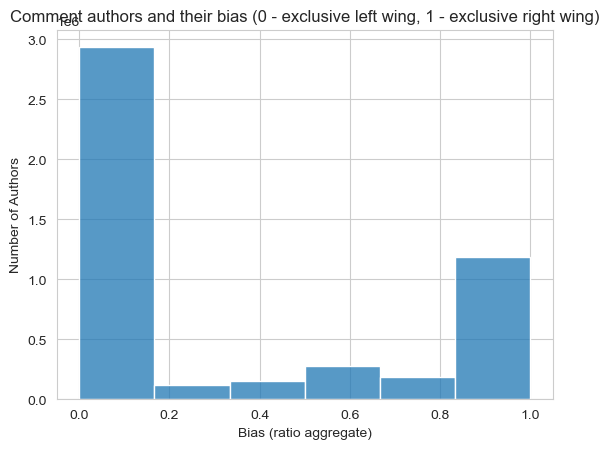

In [ ]:
g = sns.histplot(data=authors_bias_2b, x='ratio',bins=6)
g.set_title('Comment authors and their bias (0 - exclusive left wing, 1 - exclusive right wing)')
g.set_xlabel('Bias (ratio aggregate)')
g.set_ylabel('Number of Authors')

#### Analysis 2.c : using only videos from channels matched by propensity scores

Finally, seeing whether the results stay the same on a dataset where the channels have been matched by propensity scores based on more broad channel details (viewcount etc.).

In [ ]:
authors_bias = df_comments_matched.groupby(['author','media_bias_rating']).size().unstack(fill_value=0)
authors_bias['ratio'] = (authors_bias[1.0]+authors_bias[0.5])/(authors_bias[-1.0]+authors_bias[-0.5]+authors_bias[1.0]+authors_bias[0.5])
authors_bias = authors_bias.dropna()
authors_bias.head()

media_bias_rating,-1.0,-0.5,0.5,1.0,ratio
author,,,,,
450,0,0,1,0,1.0
1115,0,0,0,1,1.0
1247,1,0,0,0,0.0
1304,2,1,1,2,0.5
1334,0,0,0,1,1.0


Filter bubbles can still be observed.

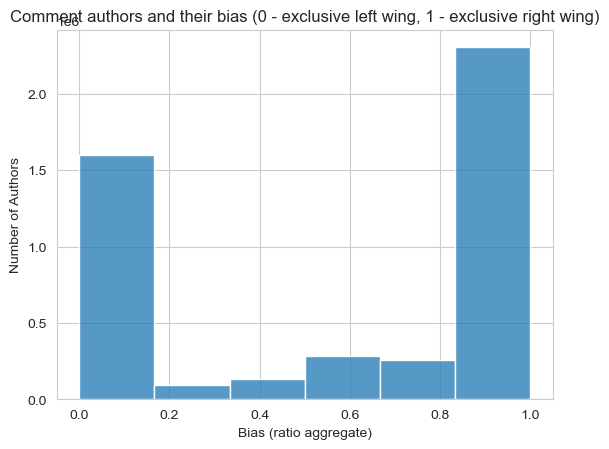

In [ ]:
g = sns.histplot(data=authors_bias, x='ratio',bins=6)
g.set_title('Comment authors and their bias (0 - exclusive left wing, 1 - exclusive right wing)')
g.set_xlabel('Bias (ratio aggregate)')
g.set_ylabel('Number of Authors')

plt.savefig("./assets/authors_bias_ratio.png", dpi=400)

In [3]:
import pandas as pd

## 4 Lexical categories

Let's investigate if there are any differences in the lexical fields used between the biases.

In [5]:
df_videos = pd.read_csv("data/df_videos.csv.gz")
df_news = pd.read_csv("data/df_news.csv.gz")
df_videos_sentiment = pd.read_csv("data/df_videos_sentiment.csv.gz")

In [ ]:
from empath import Empath
lexicon = Empath()

In [ ]:
# merge video sentiment info
df_categories = pd.merge(df_videos, df_videos_sentiment, on="display_id")[["display_id", "channel_id", "tags", "description", "title"]].copy()
# merge news bias info
df_categories = pd.merge(df_categories, df_news[["channel_id", "channel_title", "bias"]], on="channel_id")
# only 
df_categories = df_categories[(~df_categories.title.isna())].copy()

df_categories_sentiment = pd.merge(df_categories, df_videos_sentiment, on="display_id")

In [ ]:
def get_lexical_categories(df):
  lexs = []

  for bias in df.bias.unique():
    descriptions = list(df[df.bias == bias].title)

    lex = lexicon.analyze(descriptions, normalize=True)

    lexs.append(pd.DataFrame(lex, index=[bias]))

  return pd.concat(lexs)

In [ ]:
df_lexical

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Center,0.001800,0.002520,0.001176,0.005355,0.002394,0.001533,0.000444,0.001932,0.001442,0.000528,...,0.003386,0.002565,0.000307,0.001029,0.002159,0.000267,0.000640,0.000763,0.002034,0.001532
Right,0.002358,0.002756,0.000683,0.005647,0.002868,0.001073,0.000376,0.001994,0.000742,0.000967,...,0.003807,0.002450,0.000416,0.000857,0.002746,0.000229,0.001132,0.000489,0.002259,0.001184
Left,0.001243,0.001695,0.000631,0.002448,0.001891,0.000964,0.000269,0.001585,0.000868,0.000549,...,0.002935,0.002021,0.000350,0.000807,0.001444,0.000165,0.000450,0.000482,0.001304,0.000971


<AxesSubplot: title={'center': 'Lexical Similarity'}>

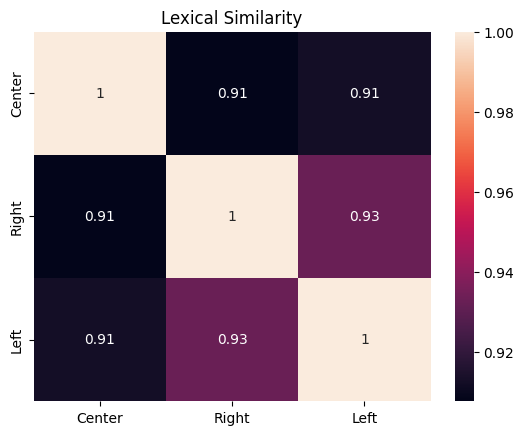

In [ ]:
df_lexical = get_lexical_categories(df_categories)

plt.title("Lexical Similarity")
sns.heatmap(df_lexical.T.corr(), annot=True)

<AxesSubplot: title={'center': 'Lexical Similarity for Video Titles Containing Trump'}>

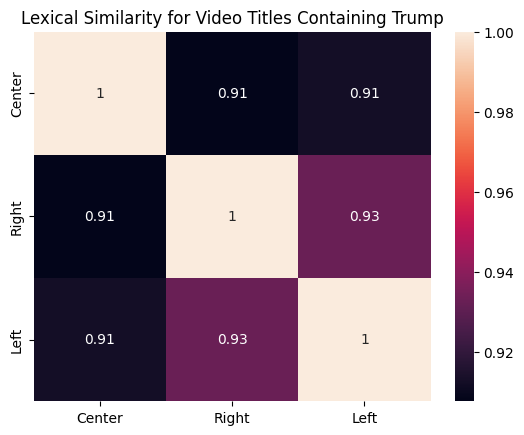

In [ ]:
fig = plt.Figure()

df_lexical = get_lexical_categories(df_categories)

df_categories_trump = df_categories[df_categories.title.str.lower().str.contains("trump")].copy()

plt.title("Lexical Similarity for Video Titles Containing Trump")
sns.heatmap(df_lexical.T.corr(), annot=True)